In [117]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/product.csv
/kaggle/input/dataset/geography.csv
/kaggle/input/dataset/train.csv
/kaggle/input/dataset/test.csv


In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

In [119]:
# set data path
geography_path = "/kaggle/input/dataset/geography.csv"
product_path = "/kaggle/input/dataset/product.csv"
test_path = "/kaggle/input/dataset/test.csv"
train_path = "/kaggle/input/dataset/train.csv"

In [120]:
# read data
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_geo = pd.read_csv(geography_path)
df_product = pd.read_csv(product_path)

In [121]:
def new_features(df):
    df["gross_profit"] = df["Revenue"] - df["COGS"]
    df["gross_margin"] = (df["gross_profit"] / df["Revenue"]) * 100
    df["profitability_index"] = df["gross_profit"] / df["COGS"]
    df["cogs_to_revenue_ratio"] = df["COGS"] / df["Revenue"]
    df["cost_control_efficiency"] = (df["Revenue"] - df["COGS"]) / df["COGS"]
    df["ROS"] = df["gross_profit"] / df["Revenue"]
    df["revenue_per_unit"] = df["Revenue"] / df["Units"]

new_features(df_train)
new_features(df_test)

# Data Preprocessing for LSTM Model

## 1. Device Check
- Check and use GPU if available.

## 2. Data Merging & Sorting
- Merge `df_train`, `df_test` with `df_product` and `df_geo`.
- Convert `Date` to datetime, sort by `ProductID` & `Date`, set `Date` as index.

## 3. Encoding & Scaling
- Encode categorical columns (`Category`, `Segment`, `Region`, `State`) using `LabelEncoder`.
- Normalize numerical columns (`Units`, `Revenue`, `COGS`) using `MinMaxScaler`.

## 4. ProductID Embedding
- Map `ProductID` to integer indices for embedding.

## 5. Feature Engineering
- Create features from `df_product`:
  - `category_size`: Number of products in each category.
  - `category_avg_revenue`: Average revenue per category.
  - `segment_avg_units`: Average units sold per segment.

## 6. Final Processing
- Drop unnecessary columns (`Product`, `City`, `District`, `Zip`).
- Update `df_product`, `df_geo` with encoded values.

In [122]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Merge with df_product
df_train = df_train.merge(df_product, on="ProductID", how="left")
df_test = df_test.merge(df_product, on="ProductID", how="left")

# Merge with df_geo
df_train = df_train.merge(df_geo, on="Zip", how="left")
df_test = df_test.merge(df_geo, on="Zip", how="left")

# Convert to date and sort by index
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_test["Date"] = pd.to_datetime(df_test["Date"])

df_train.sort_values(by=["ProductID", "Date"], inplace=True)
df_test.sort_values(by=["ProductID", "Date"], inplace=True)

df_train.set_index("Date", inplace=True)
df_test.set_index("Date", inplace=True)

In [123]:
df_train

,ProductID,Zip,Units,Revenue,COGS,gross_profit,gross_margin,profitability_index,cogs_to_revenue_ratio,cost_control_efficiency,ROS,revenue_per_unit,Category,Segment,Product,City,State,Region,District
Date,,,,,,,,,,,,,,,,,,,
2020-10-30,1,87121,1,4945.50,2732.883300,2212.616700,44.74,0.809627,0.5526,0.809627,0.4474,4945.50,Mix,All Season,Abbas MA-01,"Albuquerque, NM",NM,West,District #39
2020-11-29,1,23320,1,4945.50,2732.883300,2212.616700,44.74,0.809627,0.5526,0.809627,0.4474,4945.50,Mix,All Season,Abbas MA-01,"Chesapeake, VA",VA,East,District #07
2020-12-21,1,23116,1,4945.50,2732.883300,2212.616700,44.74,0.809627,0.5526,0.809627,0.4474,4945.50,Mix,All Season,Abbas MA-01,"Mechanicsville, VA",VA,East,District #07
2014-04-12,3,35205,1,10458.00,11281.044600,-823.044600,-7.87,-0.072958,1.0787,-0.072958,-0.0787,10458.00,Mix,All Season,Abbas MA-03,"Birmingham, AL",AL,East,District #19
2014-04-12,3,22180,1,10458.00,11281.044600,-823.044600,-7.87,-0.072958,1.0787,-0.072958,-0.0787,10458.00,Mix,All Season,Abbas MA-03,"Vienna, VA",VA,East,District #07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,2412,75935,2,2885.40,1957.455360,927.944640,32.16,0.474057,0.6784,0.474057,0.3216,1442.70,Youth,Youth,Aliqui YY-21,"Center, TX",TX,Central,District #24
2020-12-22,2412,54155,1,1417.50,961.632000,455.868000,32.16,0.474057,0.6784,0.474057,0.3216,1417.50,Youth,Youth,Aliqui YY-21,"Oneida, WI",WI,Central,District #26
2020-12-26,2412,54235,4,5670.00,3846.528000,1823.472000,32.16,0.474057,0.6784,0.474057,0.3216,1417.50,Youth,Youth,Aliqui YY-21,"Sturgeon Bay, WI",WI,Central,District #26


In [124]:
# Process label columns
label_encoders = {}
for col in ["Category", "Segment", "Region", "State"]:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])  # Ensure consistency
    label_encoders[col] = le  # Lưu encoder để sử dụng sau

# Scale numerical columns
scalers = {}
numeric_cols = ["Units", "Revenue", "COGS", "gross_profit", "gross_margin", "profitability_index", "cogs_to_revenue_ratio", "cost_control_efficiency", "ROS", "revenue_per_unit"]

for col in numeric_cols:
    scalers[col] = MinMaxScaler()
    df_train[col] = scalers[col].fit_transform(df_train[[col]])
    df_test[col] = scalers[col].transform(df_test[[col]])

# Embedding ProductID
product_ids = list(set(df_train["ProductID"]).union(set(df_test["ProductID"])))
product_id_to_idx = {pid: idx for idx, pid in enumerate(product_ids)}

df_train["ProductID_seq"] = df_train["ProductID"].map(product_id_to_idx)
df_test["ProductID_seq"] = df_test["ProductID"].map(product_id_to_idx)

# Drop unnecessary columns
drop_cols = ["Product", "City", "District", "Zip"]
df_train.drop(columns=drop_cols, inplace=True)
df_test.drop(columns=drop_cols, inplace=True)

df_product["Category"] = label_encoders["Category"].transform(df_product["Category"])
df_product["Segment"] = label_encoders["Segment"].transform(df_product["Segment"])

df_geo["Region"] = label_encoders["Region"].transform(df_geo["Region"])
df_geo["State"] = label_encoders["State"].transform(df_geo["State"])

In [125]:
# Add product metadata features
def create_product_features(df, df_product):
    # Count products per category
    category_counts = df_product.groupby('Category').size()
    df['category_size'] = df['Category'].map(category_counts)
    
    # Calculate average revenue per category
    category_avg_revenue = df.groupby('Category')['Revenue'].mean()
    df['category_avg_revenue'] = df['Category'].map(category_avg_revenue)
    
    # Calculate average units per segment
    segment_avg_units = df.groupby('Segment')['Units'].mean()
    df['segment_avg_units'] = df['Segment'].map(segment_avg_units)
    
    return df

# Apply feature creation
df_train = create_product_features(df_train, df_product)
df_test = create_product_features(df_test, df_product)

In [126]:
df_train

,ProductID,Units,Revenue,COGS,gross_profit,gross_margin,profitability_index,cogs_to_revenue_ratio,cost_control_efficiency,ROS,revenue_per_unit,Category,Segment,State,Region,ProductID_seq,category_size,category_avg_revenue,segment_avg_units
Date,,,,,,,,,,,,,,,,,,,
2020-10-30,1,0.000000,0.013521,0.008211,0.134953,0.912869,0.826637,0.087131,0.826637,0.912869,0.111488,0,0,30,2,0,201,0.012442,0.000563
2020-11-29,1,0.000000,0.013521,0.008211,0.134953,0.912869,0.826637,0.087131,0.826637,0.912869,0.111488,0,0,43,1,0,201,0.012442,0.000563
2020-12-21,1,0.000000,0.013521,0.008211,0.134953,0.912869,0.826637,0.087131,0.826637,0.912869,0.111488,0,0,43,1,0,201,0.012442,0.000563
2014-04-12,3,0.000000,0.030020,0.036082,0.109704,0.034719,0.016106,0.965281,0.016106,0.034719,0.247524,0,0,1,1,1,201,0.012442,0.000563
2014-04-12,3,0.000000,0.030020,0.036082,0.109704,0.034719,0.016106,0.965281,0.016106,0.034719,0.247524,0,0,43,1,1,201,0.012442,0.000563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,2412,0.023256,0.007356,0.005683,0.124268,0.702888,0.518463,0.297112,0.518463,0.702888,0.025046,3,7,41,0,1767,148,0.005427,0.001005
2020-12-22,2412,0.000000,0.002962,0.002436,0.120341,0.702888,0.518463,0.297112,0.518463,0.702888,0.024424,3,7,46,0,1767,148,0.005427,0.001005
2020-12-26,2412,0.069767,0.015690,0.011842,0.131716,0.702888,0.518463,0.297112,0.518463,0.702888,0.024424,3,7,46,0,1767,148,0.005427,0.001005


In [127]:
df_test = df_test.dropna()
df_train = df_train.dropna()

In [128]:
df_train

,ProductID,Units,Revenue,COGS,gross_profit,gross_margin,profitability_index,cogs_to_revenue_ratio,cost_control_efficiency,ROS,revenue_per_unit,Category,Segment,State,Region,ProductID_seq,category_size,category_avg_revenue,segment_avg_units
Date,,,,,,,,,,,,,,,,,,,
2020-10-30,1,0.000000,0.013521,0.008211,0.134953,0.912869,0.826637,0.087131,0.826637,0.912869,0.111488,0,0,30,2,0,201,0.012442,0.000563
2020-11-29,1,0.000000,0.013521,0.008211,0.134953,0.912869,0.826637,0.087131,0.826637,0.912869,0.111488,0,0,43,1,0,201,0.012442,0.000563
2020-12-21,1,0.000000,0.013521,0.008211,0.134953,0.912869,0.826637,0.087131,0.826637,0.912869,0.111488,0,0,43,1,0,201,0.012442,0.000563
2014-04-12,3,0.000000,0.030020,0.036082,0.109704,0.034719,0.016106,0.965281,0.016106,0.034719,0.247524,0,0,1,1,1,201,0.012442,0.000563
2014-04-12,3,0.000000,0.030020,0.036082,0.109704,0.034719,0.016106,0.965281,0.016106,0.034719,0.247524,0,0,43,1,1,201,0.012442,0.000563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,2412,0.023256,0.007356,0.005683,0.124268,0.702888,0.518463,0.297112,0.518463,0.702888,0.025046,3,7,41,0,1767,148,0.005427,0.001005
2020-12-22,2412,0.000000,0.002962,0.002436,0.120341,0.702888,0.518463,0.297112,0.518463,0.702888,0.024424,3,7,46,0,1767,148,0.005427,0.001005
2020-12-26,2412,0.069767,0.015690,0.011842,0.131716,0.702888,0.518463,0.297112,0.518463,0.702888,0.024424,3,7,46,0,1767,148,0.005427,0.001005


# TimeSeriesDataset with Product and Geometry Metadata

## 1. Dataset Initialization
- Stores the dataset (`df`) and sets `window_size` (default = 30).

## 2. Dataset Length
- Returns the number of valid sequences: `len(df) - window_size`.

## 3. Data Retrieval (`__getitem__`)
- Extracts a time window (`x`) and the next time step's target values (`y`).
- Converts the following features into tensors:
  - **Categorical Features**: `ProductID_seq`, `Category`, `Segment`, `Region`, `State`.
  - **Metadata**: `category_size`, `category_avg_revenue`, `segment_avg_units`.
  - **Target Variables**: `Units`, `Revenue`.

## 4. Output Format
- Returns a dictionary containing all input features and targets as PyTorch tensors.


In [129]:
# Modified Dataset class to include product metadata
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size=30):
        self.window_size = window_size
        self.data = df

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data.iloc[idx:idx+self.window_size]
        y = self.data.iloc[idx+self.window_size][["Units", "Revenue"]]
        
        return {
            "product_id": torch.tensor(x["ProductID_seq"].values, dtype=torch.long),
            "category": torch.tensor(x["Category"].values, dtype=torch.long),
            "segment": torch.tensor(x["Segment"].values, dtype=torch.long),
            "state": torch.tensor(x["State"].values, dtype=torch.long),
            "region": torch.tensor(x["Region"].values, dtype=torch.long),
            "cogs": torch.tensor(x["COGS"].values, dtype=torch.float32),
            "category_size": torch.tensor(x["category_size"].values, dtype=torch.float32),
            "category_avg_revenue": torch.tensor(x["category_avg_revenue"].values, dtype=torch.float32),
            "segment_avg_units": torch.tensor(x["segment_avg_units"].values, dtype=torch.float32),
            "gross_profit": torch.tensor(x["gross_profit"].values, dtype=torch.float32),
            "gross_margin": torch.tensor(x["gross_margin"].values, dtype=torch.float32),
            "profitability_index": torch.tensor(x["profitability_index"].values, dtype=torch.float32),
            "cogs_to_revenue_ratio": torch.tensor(x["cogs_to_revenue_ratio"].values, dtype=torch.float32),
            "cost_control_efficiency": torch.tensor(x["cost_control_efficiency"].values, dtype=torch.float32),
            "ros": torch.tensor(x["ROS"].values, dtype=torch.float32),
            "revenue_per_unit": torch.tensor(x["revenue_per_unit"].values, dtype=torch.float32),
            "units": torch.tensor(y["Units"], dtype=torch.float32),
            "revenue": torch.tensor(y["Revenue"], dtype=torch.float32),
        }


# Enhanced LSTM Model with Metadata

## 1. Embeddings
- Learn representations for categorical variables:
  - `ProductID`, `Category`, `Segment`, `Region`, `State`.

## 2. LSTM Architecture
- Input: Concatenated embeddings.
- LSTM: 
  - 2 layers, `hidden_dim=16`.
  - `dropout=0.2` to prevent overfitting.

## 3. Attention Mechanism
- Computes attention weights over LSTM outputs.
- Generates a context vector using weighted sum.

## 4. Metadata Integration
- Uses product metadata:
  - `category_size`
  - `category_avg_revenue`
  - `segment_avg_units`
- Concatenates metadata with context vector.

## 5. Fully Connected Layers
- `fc1`: Merges context and metadata.
- `fc2`: Outputs `Units` & `Revenue` predictions.

## 6. Forward Pass
- Embeddings → LSTM → Attention → Metadata Fusion → Dense Layers → Output.


In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Enhanced LSTM Model with product metadata
class EnhancedSalesLSTM(nn.Module):
    def __init__(self, product_vocab_size, category_size, segment_size, region_size, state_size,
                 embedding_dim=8, hidden_dim=16):
        super(EnhancedSalesLSTM, self).__init__()
        
        # Embeddings for categorical variables
        self.product_embedding = nn.Embedding(product_vocab_size, embedding_dim)
        self.category_embedding = nn.Embedding(category_size, embedding_dim // 2)
        self.segment_embedding = nn.Embedding(segment_size, embedding_dim // 2)
        self.region_embedding = nn.Embedding(region_size, embedding_dim // 4)
        self.state_embedding = nn.Embedding(state_size, embedding_dim // 4)
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=embedding_dim * 2 + embedding_dim // 2, 
            hidden_size=hidden_dim,
            num_layers=2,
            dropout=0.2,
            batch_first=True
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )
        
        # Fully connected layers with metadata
        self.fc1 = nn.Linear(hidden_dim + 10, hidden_dim)  # +10 for additional metadata features
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim, 2)
        
    def forward(self, product_id, category, segment, region, state, 
                category_size, category_avg_revenue, segment_avg_units,
                cogs, gross_profit, profitability_index, cogs_to_revenue_ratio,
                cost_control_efficiency, ros, revenue_per_unit, gross_margin):
        # Get embeddings
        product_emb = self.product_embedding(product_id)
        category_emb = self.category_embedding(category)
        segment_emb = self.segment_embedding(segment)
        region_emb = self.region_embedding(region)
        state_emb = self.state_embedding(state)
        
        # Combine embeddings
        combined = torch.cat([
            product_emb,
            category_emb,
            segment_emb,
            region_emb,
            state_emb
        ], dim=2)
        
        # LSTM
        lstm_out, (hidden, _) = self.lstm(combined)
        
        # Attention
        attention_weights = self.attention(lstm_out)
        context = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Combine with metadata
        metadata = torch.stack([
            category_size[:, -1],
            category_avg_revenue[:, -1],
            segment_avg_units[:, -1],
            cogs[:, -1],
            gross_profit[:, -1],
            profitability_index[:, -1],
            cogs_to_revenue_ratio[:, -1],
            cost_control_efficiency[:, -1],
            ros[:, -1],
            revenue_per_unit[:, -1]
        ], dim=1)
        
        # Final predictions
        combined_features = torch.cat([context, metadata], dim=1)
        x = self.fc1(combined_features)
        x = torch.relu(x)
        x = self.dropout(x)
        output = self.fc2(x)
        
        return output


# LSTM Training with Early Stopping

## 1. Training Process
- Iterate through `num_epochs`.
- Train using `train_loader`, compute loss on `Units` and `Revenue`.
- Apply gradient clipping.

## 2. Validation
- Evaluate on `val_loader`, track validation loss.
- Save best model as `best_model.pth`.

## 3. Early Stopping
- Stop training if no improvement for `patience` epochs.

## 4. Progress Tracking
- Use `tqdm` for progress bars.
- Print loss after each epoch.


In [131]:
from tqdm import tqdm
import torch.nn.functional as F

# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        # Training
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for batch in train_bar:
            # Move batch to GPU
            batch = {k: v.to(device) for k, v in batch.items()}
            
            optimizer.zero_grad()
            output = model(
                batch["product_id"], batch["category"], batch["segment"],
                batch["region"], batch["state"], batch["category_size"],
                batch["category_avg_revenue"], batch["segment_avg_units"],
                batch["cogs"], batch["gross_profit"], batch["gross_margin"],
                batch["profitability_index"], batch["cogs_to_revenue_ratio"],
                batch["cost_control_efficiency"], batch["ros"], batch["revenue_per_unit"]
            )
            # Compute loss with both unit and revenue
            loss = criterion(output, torch.stack([batch["units"], batch["revenue"]], dim=1))
            if torch.isnan(loss) or torch.isinf(loss):
                print("NaN detected in loss, stopping training.")
                return
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            
            train_bar.set_postfix(loss=loss.item())

        # Validation
        model.eval()
        val_loss = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
        with torch.no_grad():
            for batch in val_bar:
                batch = {k: v.to(device) for k, v in batch.items()}  # Chuyển batch sang GPU

                output = model(
                    batch["product_id"], batch["category"], batch["segment"],
                    batch["region"], batch["state"], batch["category_size"],
                    batch["category_avg_revenue"], batch["segment_avg_units"],
                    batch["cogs"], batch["gross_profit"], batch["gross_margin"],
                    batch["profitability_index"], batch["cogs_to_revenue_ratio"],
                    batch["cost_control_efficiency"], batch["ros"], batch["revenue_per_unit"]
                )
                batch_loss = criterion(output, torch.stack([batch["units"], batch["revenue"]], dim=1)).item()
                val_loss += batch_loss

                val_bar.set_postfix(loss=batch_loss)

        # Mean loss per sample
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


# Initialize hyperparemeter and training

In [132]:
# set up argument
batch_size = 64 
lr = 3e-4
window_size = 60
num_epochs = 3

In [133]:
import torch
torch.cuda.empty_cache() 
# Model initialization and training
model = EnhancedSalesLSTM(
    product_vocab_size=len(product_ids),
    category_size=len(label_encoders['Category'].classes_),
    segment_size=len(label_encoders['Segment'].classes_),
    region_size=len(label_encoders['Region'].classes_),
    state_size=len(label_encoders['State'].classes_)
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# initialize data
full_dataset = TimeSeriesDataset(df_train, window_size=window_size)

# Split train to train và validation (0.9,0,1)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Build dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TimeSeriesDataset(df_test, window_size=window_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer,num_epochs=num_epochs)

Epoch 1: Train Loss = 15.3933, Val Loss = 0.0001


Epoch 2: Train Loss = 0.0001, Val Loss = 0.0001


Epoch 3: Train Loss = 0.0001, Val Loss = 0.0001


# Model Evaluation for LSTM

## 1. Metric Calculation
- Compute R², MAPE, and RMSE for `Units` and `Revenue`.

## 2. Model Evaluation
- Iterate over `test_loader`, collect actual and predicted values.
- Apply inverse transformation to retrieve original scale.

## 3. Time-Series Processing
- Extract test set dates and convert to monthly periods.
- Aggregate values by month for analysis.

## 4. Visualization
- Plot "Actual vs Predicted Revenue" per month.
- Plot "Actual vs Predicted Units" per month.

## 5. Output
- Print evaluation metrics.

Evaluating: 100%|██████████| 1166/1166 [01:32<00:00, 12.67it/s]


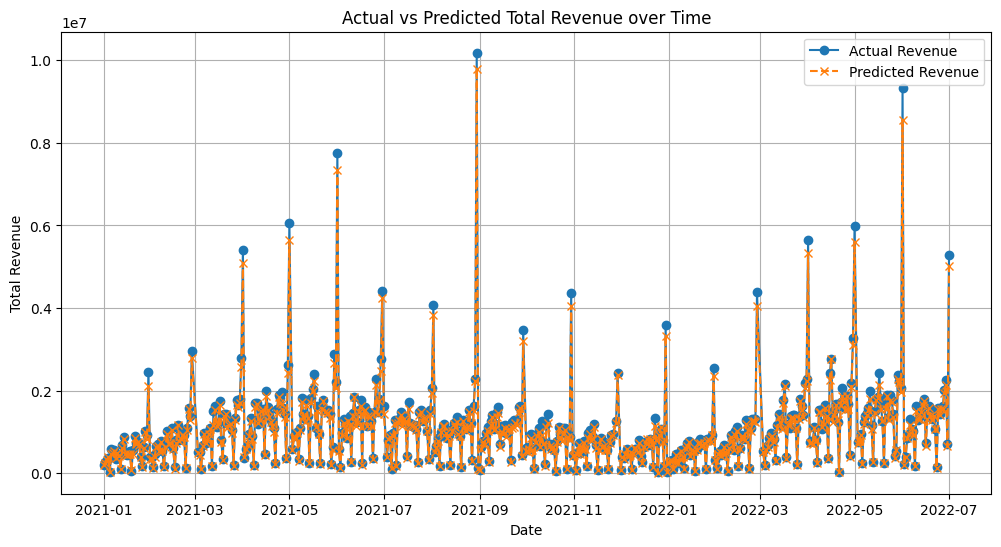

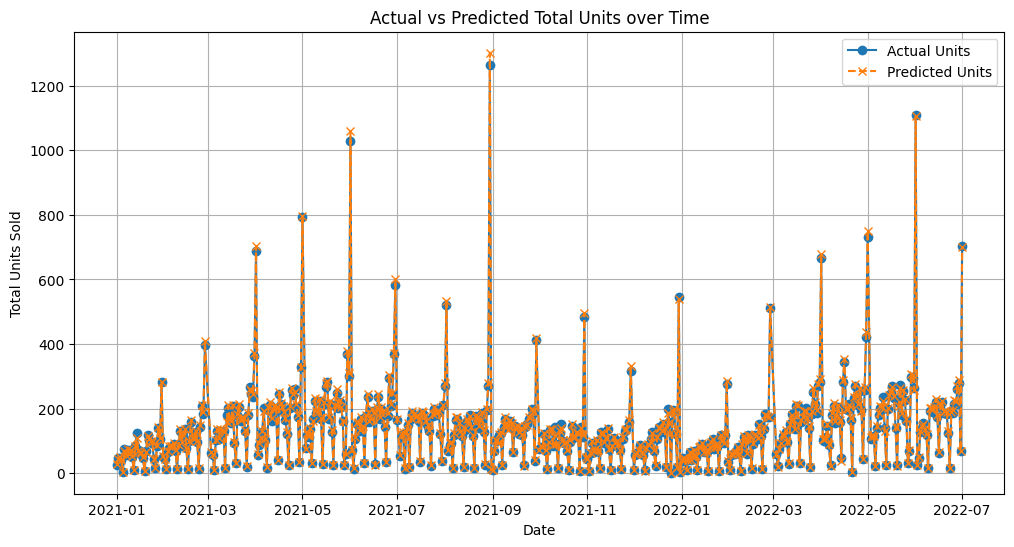

{'units': {'R²': -0.006243301872511209, 'MAPE': 0.054847494, 'RMSE': 0.32145333}, 'revenue': {'R²': 0.6079299178285558, 'MAPE': 0.3574122, 'RMSE': 3644.8125}}


In [134]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from tqdm import tqdm


# Compute metric
def calculate_metrics(y_true, y_pred):
    return {
        "R²": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False)
    }

# Evaluate model
def evaluate_model(model, test_loader, device, scalers):
    model.eval()
    all_true_units, all_pred_units = [], []
    all_true_revenue, all_pred_revenue = [], []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}

            # Predict
            output = model(
                batch["product_id"], batch["category"], batch["segment"],
                batch["region"], batch["state"], batch["category_size"],
                batch["category_avg_revenue"], batch["segment_avg_units"],
                batch["cogs"], batch["gross_profit"], batch["gross_margin"],
                batch["profitability_index"], batch["cogs_to_revenue_ratio"],
                batch["cost_control_efficiency"], batch["ros"], batch["revenue_per_unit"]
            )

            # Stores predict and actual
            all_true_units.extend(batch["units"].cpu().numpy().reshape(-1, 1))
            all_pred_units.extend(output[:, 0].cpu().numpy().reshape(-1, 1))

            all_true_revenue.extend(batch["revenue"].cpu().numpy().reshape(-1, 1))
            all_pred_revenue.extend(output[:, 1].cpu().numpy().reshape(-1, 1))

    # Convert to numpy array
    all_true_units = np.array(all_true_units)
    all_pred_units = np.array(all_pred_units)
    all_true_revenue = np.array(all_true_revenue)
    all_pred_revenue = np.array(all_pred_revenue)

    # Inverse transform from MinmaxScaler
    all_true_units = scalers["Units"].inverse_transform(all_true_units)
    all_pred_units = scalers["Units"].inverse_transform(all_pred_units)

    all_true_revenue = scalers["Revenue"].inverse_transform(all_true_revenue)
    all_pred_revenue = scalers["Revenue"].inverse_transform(all_pred_revenue)

    # take window size data
    if len(df_test.index) > window_size:
        test_dates = df_test.index[window_size:].to_list()
    else:
        test_dates = df_test.index.to_list()

    num_samples = min(len(test_dates), len(all_true_revenue))
    all_dates = pd.to_datetime(test_dates[:num_samples])

    # Compute metrics
    metrics = {
        "units": calculate_metrics(all_true_units[:num_samples], all_pred_units[:num_samples]),
        "revenue": calculate_metrics(all_true_revenue[:num_samples], all_pred_revenue[:num_samples])
    }

    # Draw plot actual and predict Revenue over time
    df_results_revenue = pd.DataFrame({
        "date": all_dates,
        "actual_revenue": all_true_revenue[:num_samples].flatten(),
        "predicted_revenue": all_pred_revenue[:num_samples].flatten()
    })

    df_results_revenue = df_results_revenue.groupby("date").sum()

    plt.figure(figsize=(12, 6))
    plt.plot(df_results_revenue.index, df_results_revenue["actual_revenue"], label="Actual Revenue", marker='o')
    plt.plot(df_results_revenue.index, df_results_revenue["predicted_revenue"], label="Predicted Revenue", linestyle="dashed", marker='x')
    plt.xlabel("Date")
    plt.ylabel("Total Revenue")
    plt.legend()
    plt.title("Actual vs Predicted Total Revenue over Time")
    plt.grid()
    plt.show()

    # Draw plot actual and predict Unit over time
    df_results_units = pd.DataFrame({
        "date": all_dates,
        "actual_units": all_true_units[:num_samples].flatten(),
        "predicted_units": all_pred_units[:num_samples].flatten()
    })

    df_results_units = df_results_units.groupby("date").sum()

    plt.figure(figsize=(12, 6))
    plt.plot(df_results_units.index, df_results_units["actual_units"], label="Actual Units", marker='o')
    plt.plot(df_results_units.index, df_results_units["predicted_units"], label="Predicted Units", linestyle="dashed", marker='x')
    plt.xlabel("Date")
    plt.ylabel("Total Units Sold")
    plt.legend()
    plt.title("Actual vs Predicted Total Units over Time")
    plt.grid()
    plt.show()

    return metrics

# Run evaluation
metrics = evaluate_model(model, test_loader, device, scalers)
print(metrics)


Evaluating: 100%|██████████| 1166/1166 [01:32<00:00, 12.56it/s]


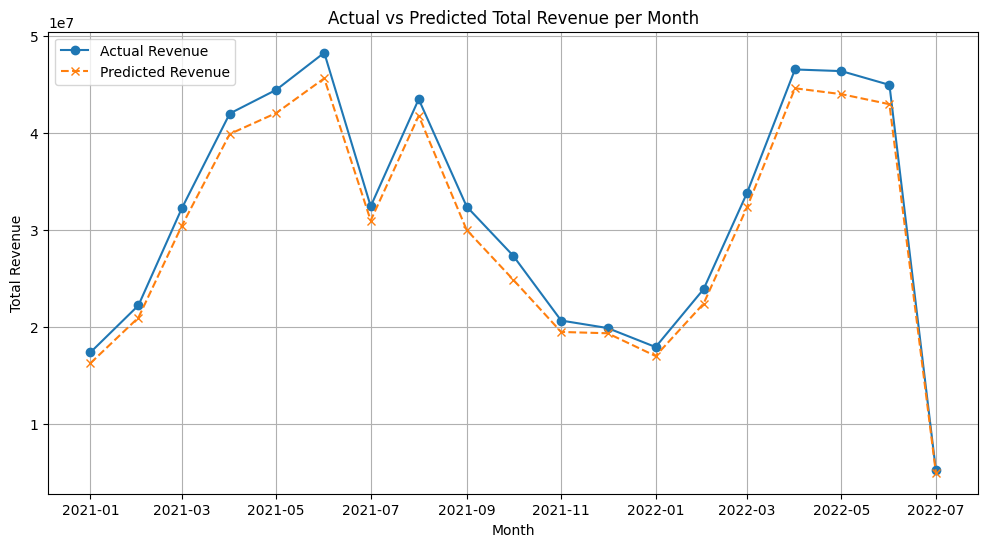

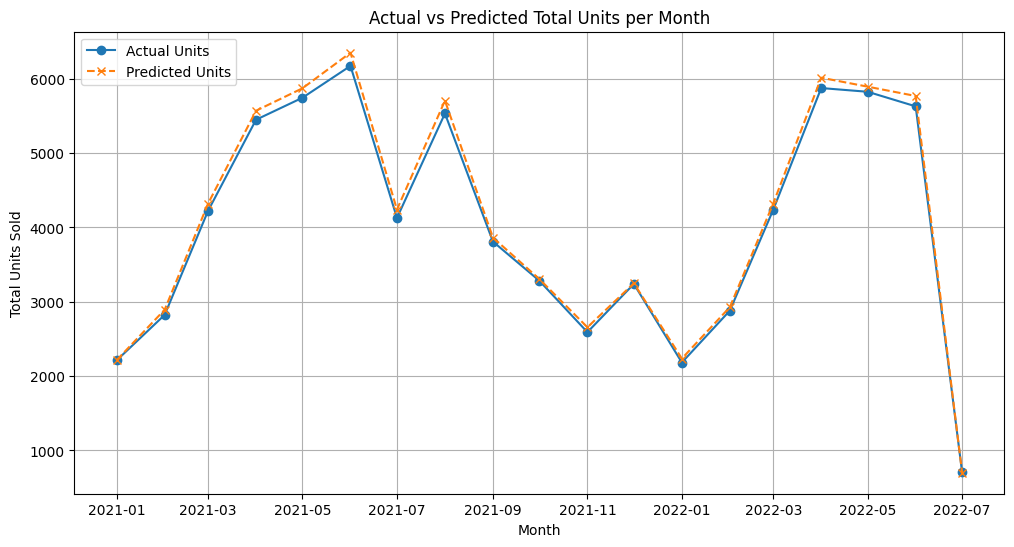

{'units': {'R²': -0.006243301872511209, 'MAPE': 0.054847494, 'RMSE': 0.32145333}, 'revenue': {'R²': 0.6079299178285558, 'MAPE': 0.3574122, 'RMSE': 3644.8125}}


In [135]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from tqdm import tqdm

# Draw over month
def calculate_metrics(y_true, y_pred):
    return {
        "R²": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False)
    }

def evaluate_model(model, test_loader, device, scalers):
    model.eval()
    all_true_units, all_pred_units = [], []
    all_true_revenue, all_pred_revenue = [], []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}

            output = model(
                batch["product_id"], batch["category"], batch["segment"],
                batch["region"], batch["state"], batch["category_size"],
                batch["category_avg_revenue"], batch["segment_avg_units"],
                batch["cogs"], batch["gross_profit"], batch["gross_margin"],
                batch["profitability_index"], batch["cogs_to_revenue_ratio"],
                batch["cost_control_efficiency"], batch["ros"], batch["revenue_per_unit"]
            )
            all_true_units.extend(batch["units"].cpu().numpy().reshape(-1, 1))
            all_pred_units.extend(output[:, 0].cpu().numpy().reshape(-1, 1))

            all_true_revenue.extend(batch["revenue"].cpu().numpy().reshape(-1, 1))
            all_pred_revenue.extend(output[:, 1].cpu().numpy().reshape(-1, 1))

    all_true_units = np.array(all_true_units)
    all_pred_units = np.array(all_pred_units)
    all_true_revenue = np.array(all_true_revenue)
    all_pred_revenue = np.array(all_pred_revenue)

    all_true_units = scalers["Units"].inverse_transform(all_true_units)
    all_pred_units = scalers["Units"].inverse_transform(all_pred_units)

    all_true_revenue = scalers["Revenue"].inverse_transform(all_true_revenue)
    all_pred_revenue = scalers["Revenue"].inverse_transform(all_pred_revenue)

    if len(df_test.index) > window_size:
        test_dates = df_test.index[window_size:].to_list()
    else:
        test_dates = df_test.index.to_list()

    num_samples = min(len(test_dates), len(all_true_revenue))
    all_dates = pd.to_datetime(test_dates[:num_samples])

    # Convert to month
    all_dates = all_dates.to_period("M").to_timestamp()

    metrics = {
        "units": calculate_metrics(all_true_units[:num_samples], all_pred_units[:num_samples]),
        "revenue": calculate_metrics(all_true_revenue[:num_samples], all_pred_revenue[:num_samples])
    }

    df_results_revenue = pd.DataFrame({
        "date": all_dates,
        "actual_revenue": all_true_revenue[:num_samples].flatten(),
        "predicted_revenue": all_pred_revenue[:num_samples].flatten()
    })

    df_results_revenue = df_results_revenue.groupby("date").sum()

    plt.figure(figsize=(12, 6))
    plt.plot(df_results_revenue.index, df_results_revenue["actual_revenue"], label="Actual Revenue", marker='o')
    plt.plot(df_results_revenue.index, df_results_revenue["predicted_revenue"], label="Predicted Revenue", linestyle="dashed", marker='x')
    plt.xlabel("Month")
    plt.ylabel("Total Revenue")
    plt.legend()
    plt.title("Actual vs Predicted Total Revenue per Month")
    plt.grid()
    plt.show()

    df_results_units = pd.DataFrame({
        "date": all_dates,
        "actual_units": all_true_units[:num_samples].flatten(),
        "predicted_units": all_pred_units[:num_samples].flatten()
    })

    df_results_units = df_results_units.groupby("date").sum()

    plt.figure(figsize=(12, 6))
    plt.plot(df_results_units.index, df_results_units["actual_units"], label="Actual Units", marker='o')
    plt.plot(df_results_units.index, df_results_units["predicted_units"], label="Predicted Units", linestyle="dashed", marker='x')
    plt.xlabel("Month")
    plt.ylabel("Total Units Sold")
    plt.legend()
    plt.title("Actual vs Predicted Total Units per Month")
    plt.grid()
    plt.show()

    return metrics

metrics = evaluate_model(model, test_loader, device, scalers)
print(metrics)


Evaluating: 100%|██████████| 1166/1166 [01:32<00:00, 12.57it/s]


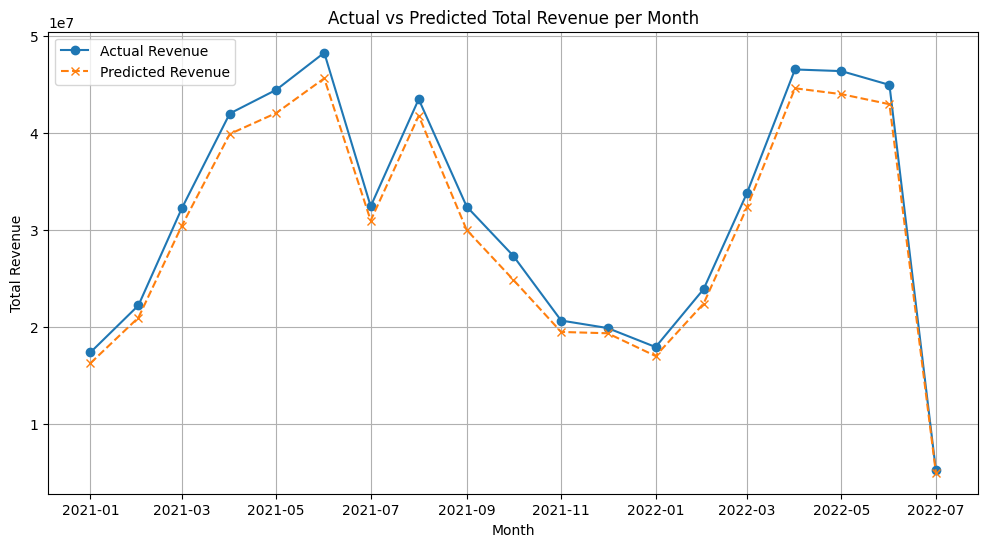

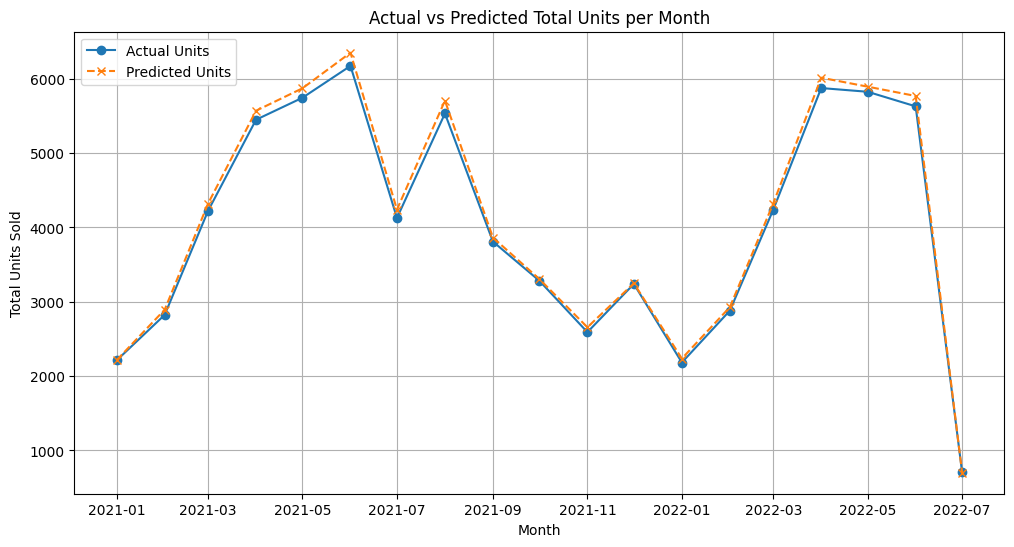

{'units': {'R²': -0.006243301872511209, 'MAPE': 0.054847494, 'RMSE': 0.32145333}, 'revenue': {'R²': 0.6079299178285558, 'MAPE': 0.3574122, 'RMSE': 3644.8125}}


In [136]:
# Run
metrics = evaluate_model(model, test_loader, device, scalers)
print(metrics)